In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
classifier_model ="https://hub.tensorflow.google.cn/google/tf2-preview/mobilenet_v2/classification/4" 

In [3]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

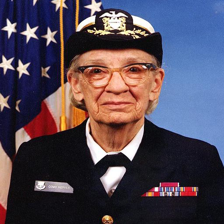

In [4]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [5]:
grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper.shape

(224, 224, 3)

In [6]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [7]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

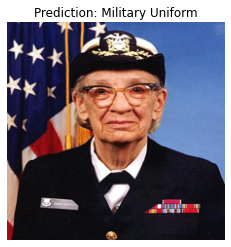

In [9]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [10]:
data_root = tf.keras.utils.get_file(
    'flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
     untar=True)

In [11]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [12]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [13]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [14]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'spider web', 'rubber eraser', 'ski', 'cardoon', 'daisy',
       'daisy', 'daisy', 'daisy', 'daisy', 'broccoli', 'sea urchin',
       'daisy', 'pot', 'daisy', 'greenhouse', 'daisy', 'bubble', 'orange',
       'barn spider', 'goldfish', 'sulphur butterfly', 'cardoon', 'vase',
       'apiary', 'park bench', 'daisy', 'cardoon', 'daisy', 'daisy',
       'daisy', 'chickadee'], dtype='<U30')

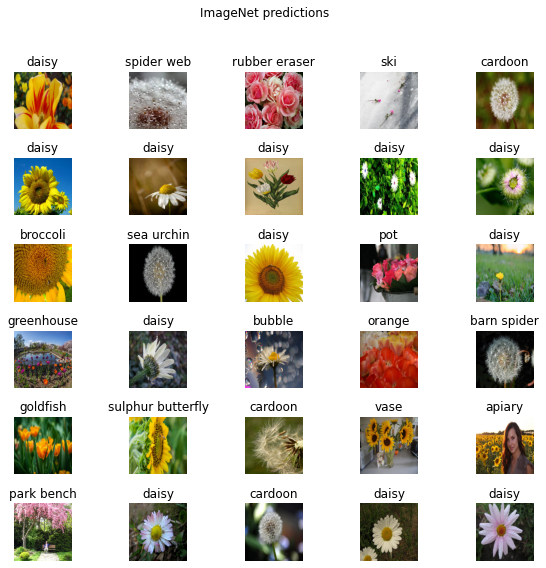

In [15]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [16]:
feature_extractor_model = "https://hub.tensorflow.google.cn/google/tf2-preview/mobilenet_v2/feature_vector/4" 

In [17]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [18]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [19]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
predictions = model(image_batch)

In [21]:
predictions.shape

TensorShape([32, 5])

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

In [23]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [24]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 34s 297ms/step - loss: 0.2709 - acc: 0.9062
Epoch 2/2
115/115 [==============================] - 33s 290ms/step - loss: 0.2452 - acc: 0.9375


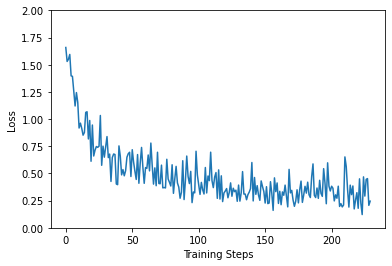

In [25]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

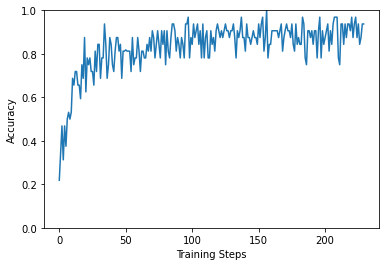

In [26]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [27]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [28]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [29]:
label_id = np.argmax(label_batch, axis=-1)

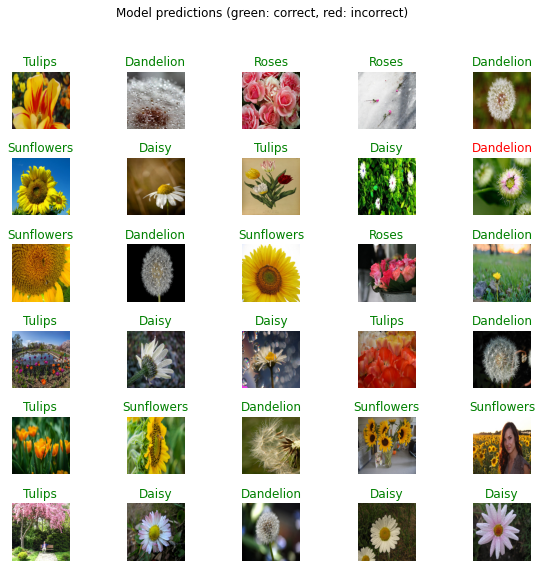

In [30]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [31]:
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/saved_models/1603420693/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1603420693/assets


'/tmp/saved_models/1603420693'

In [32]:
reloaded = tf.keras.models.load_model(export_path)

In [33]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [34]:
abs(reloaded_result_batch - result_batch).max()

0.0